# Visualizing Dirichelet Distribution

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path
from scipy.stats import gaussian_kde
from scipy.interpolate import griddata
import matplotlib.colors as colors
from tqdm.notebook import tqdm 


In [30]:

def largest_pl_score_event(pl_scores):

    max_pl_score = max(pl_scores)
    event = [int(score == max_pl_score) for score in pl_scores]
    return event

def top_two_pl_score_event(pl_scores): 
    sorted_pl_scores = sorted(pl_scores, reverse=True)
    event = [int(score in sorted_pl_scores[:2]) for score in pl_scores]
    return event
min_num_samples_for_subjective_prob = 10 #1_000
max_num_samples_for_subjective_prob = 10 #0_000

num_cands_incumbent_party = 2
num_cands_opposition_party = 2

num_voters = 1_000
pr_incumbent_party_voters = 0.5
concentration_param_for_num_voters = 100

binom_ci_threshold_for_events = 0.01
min_num_samples_for_events = 1_000
max_num_samples_for_events = 1_000#100_000

def generate_probabilities(
    pl_scores, 
    num_voters,
    concentration_param, 
    manipulation_level,
    incumbent_candidates, 
    opposition_candidates, 
    num_samples = 1000):

    """
    Find the subjective probability of each candidate winning the election given the plurality scores of the candidates.
    """

    candidates = sorted(list(pl_scores.keys()))
    
    winner_events = [[] for c in candidates]
    top_two_events = [[] for c in candidates]

    pl_samples = np.random.dirichlet(
        [((pl_scores[c] + 1) / num_voters) * concentration_param 
        for c in candidates], 
        size = num_samples)
    
    num_samples = 0 
    for pl_sample in pl_samples:

        if  np.isnan(pl_sample).any():
            continue
        # # check if any new_pl_scores is nan
        # assert not np.isnan(pl_sample).any(), "Dirichlet sample contains nan values"
            
        new_pl_scores  = list(pl_sample)

        winner_event = largest_pl_score_event(new_pl_scores)
        top_two_event = top_two_pl_score_event(new_pl_scores)

        for cidx, _ in enumerate(candidates):
            winner_events[cidx].append(winner_event[cidx])
            top_two_events[cidx].append(top_two_event[cidx])

    winner_prob = {c: np.mean(winner_events[cidx]) for cidx, c in enumerate(candidates)}
    top_two_prob = {c: np.mean(top_two_events[cidx]) for cidx, c in enumerate(candidates)}

    opposition_candidates_prob_rankings = sorted(opposition_candidates, key=lambda c: top_two_prob[c], reverse=True)
    cand_to_ignore = opposition_candidates_prob_rankings[-1]
    cand_to_ignore_idx = candidates.index(cand_to_ignore)

    cand_to_manipulate = opposition_candidates_prob_rankings[0]
    cand_to_manipulate_idx = candidates.index(cand_to_manipulate)

    strategic_winner_events = [[] for c in candidates]

    for pl_sample in pl_samples:
            
        pl_scores  = list(pl_sample)
        updated_pl_scores = pl_scores.copy()
        updated_pl_scores[cand_to_ignore_idx] = (1-manipulation_level)*pl_scores[cand_to_ignore_idx]
        
        updated_pl_scores[cand_to_manipulate_idx] = pl_scores[cand_to_manipulate_idx] + manipulation_level*pl_scores[cand_to_ignore_idx]

        strategic_winner_event = largest_pl_score_event(updated_pl_scores)

        for cidx, _ in enumerate(candidates):
            strategic_winner_events[cidx].append(strategic_winner_event[cidx])

    strategic_winner_prob = {c: np.mean(strategic_winner_events[cidx]) for cidx, c in enumerate(candidates)}

    return winner_prob, top_two_prob, strategic_winner_prob
pl_scores = {1:33, 2:35, 3:32}
concentration_param = 10
manipulation_level = 0.0
incumbent_candidates = [0, 1]
opposition_candidates = [2, 3]
print(generate_probabilities(
    pl_scores, 
    num_voters,
    concentration_param, 
    manipulation_level,
    incumbent_candidates, 
    opposition_candidates, 
    num_samples = min_num_samples_for_subjective_prob))
def get_sample_prs(pl_scores, concentration_param, num_voters, num_samples): 
    samples = []
    for v in range(num_voters): 
        pr,_,_ = generate_probabilities(
            pl_scores, 
            num_voters,
            concentration_param, 
            manipulation_level,
            incumbent_candidates, 
            opposition_candidates, 
            num_samples = num_samples)
        samples.append([pr[1], pr[2], pr[3]])
    return np.array(samples)

def get_sample_strategic_prs(pl_scores, concentration_param, num_voters, num_samples): 
    samples = []
    for v in range(num_voters): 
        _,_, pr = generate_probabilities(
            pl_scores, 
            num_voters,
            concentration_param, 
            1.0,
            incumbent_candidates, 
            opposition_candidates, 
            num_samples = num_samples)
        samples.append([pr[1], pr[2], pr[3]])
    return np.array(samples)

#get_sample_prs(pl_scores, 0.1, num_voters, 10)

({1: 0.4, 2: 0.1, 3: 0.5}, {1: 0.6, 2: 0.6, 3: 0.8}, {1: 0.4, 2: 0.1, 3: 0.5})



λ = 0.1:
  Mean probabilities: [0.540, 0.265, 0.195]
  Std deviations: [0.477, 0.421, 0.380]

λ = 1:
  Mean probabilities: [0.517, 0.260, 0.223]
  Std deviations: [0.358, 0.303, 0.296]

λ = 10:
  Mean probabilities: [0.521, 0.276, 0.203]
  Std deviations: [0.148, 0.134, 0.118]

λ = 100:
  Mean probabilities: [0.519, 0.269, 0.212]
  Std deviations: [0.049, 0.043, 0.041]

λ = 1000:
  Mean probabilities: [0.520, 0.270, 0.210]
  Std deviations: [0.016, 0.014, 0.012]

λ = 10000:
  Mean probabilities: [0.520, 0.270, 0.210]
  Std deviations: [0.005, 0.004, 0.004]


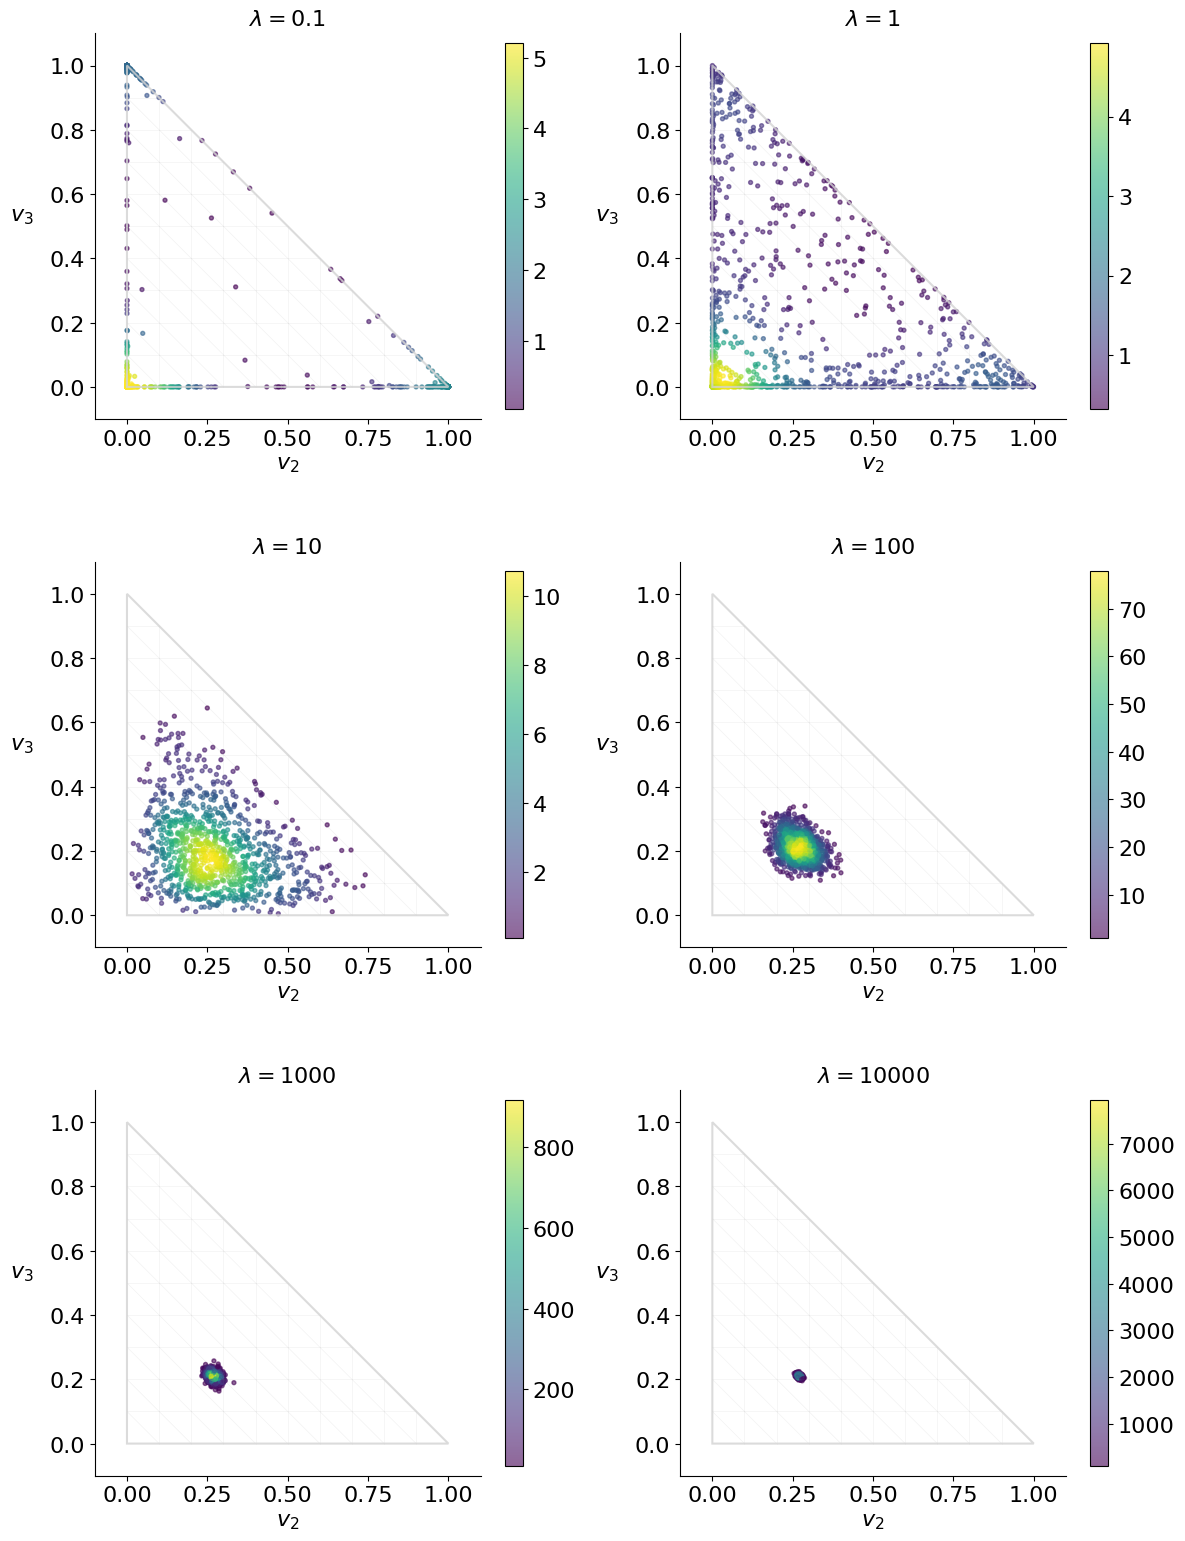

In [31]:

def plot_marshak_machina_density(lotteries, method='hexbin', figsize=(10, 8), 
                                cmap='YlOrRd', title=None, ax=None, **kwargs):
    """
    Plot density of lotteries on a Marshak-Machina right triangle.
    
    Parameters:
    -----------
    lotteries : array-like
        Array of lotteries where each row is (p1, p2, p3) with p1 + p2 + p3 = 1
    method : str
        Density visualization method: 'hexbin', 'kde', 'hist2d', 'scatter_density'
    figsize : tuple
        Figure size (width, height) - only used if ax is None
    cmap : str
        Colormap name
    title : str
        Custom title (optional)
    ax : matplotlib axis
        Existing axis to plot on (optional)
    **kwargs : additional arguments passed to plotting functions
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    
    fontsize=16
    # Create figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.get_figure()
    
    # Convert lotteries to numpy array and normalize
    lotteries = np.array(lotteries)
    sums = np.sum(lotteries, axis=1)
    if not np.allclose(sums, 1.0):
        print("Warning: Some lotteries don't sum to 1. Normalizing...")
        lotteries = lotteries / sums[:, np.newaxis]
    
    # Convert to (p2, p3) coordinates
    x_coords = lotteries[:, 1]  # p2
    y_coords = lotteries[:, 2]  # p3
    
    # Create triangle path for masking
    triangle_verts = [(0, 0), (1, 0), (0, 1), (0, 0)]
    triangle_path = Path(triangle_verts)
    
    # Plot density based on method
    if method == 'hexbin':
        plot_hexbin_density(ax, x_coords, y_coords, triangle_path, cmap, **kwargs)
    elif method == 'kde':
        plot_kde_density(ax, x_coords, y_coords, triangle_path, cmap, **kwargs)
    elif method == 'hist2d':
        plot_hist2d_density(ax, x_coords, y_coords, triangle_path, cmap, **kwargs)
    elif method == 'scatter_density':
        plot_scatter_density(ax, x_coords, y_coords, triangle_path, cmap, **kwargs)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Draw triangle outline
    if method != 'scatter_density':
        triangle = Polygon(triangle_verts[:-1], fill=False, edgecolor='black', linewidth=2, zorder=10)
        ax.add_patch(triangle)
    else:
        # For scatter density, use a light gray outline
        triangle = Polygon(triangle_verts[:-1], fill=False, edgecolor='lightgray', 
                          linewidth=1.5, alpha=0.8, zorder=2)
        ax.add_patch(triangle)
    
    # Add grid lines (lighter for scatter density)
    grid_alpha = 0.1 if method == 'scatter_density' else 0.2
    for i in range(1, 10):
        alpha = i / 10
        ax.plot([0, 1-alpha], [alpha, alpha], 'gray', alpha=grid_alpha, linewidth=0.5, zorder=1)
        ax.plot([alpha, alpha], [0, 1-alpha], 'gray', alpha=grid_alpha, linewidth=0.5, zorder=1)
        ax.plot([alpha, 0], [0, alpha], 'gray', alpha=grid_alpha, linewidth=0.5, zorder=1)
    
    # Label vertices
    
    # Set axis properties
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    # set font size fo xticks and yticks
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xlabel('$v_2$', fontsize=fontsize)
    ax.set_ylabel('$v_3$', fontsize=fontsize, rotation=0, labelpad=20)    
    # Set title
    if title:
        ax.set_title(title, fontsize=fontsize)
    else:
        ax.set_title(f'Marshak-Machina Triangle - Density Plot ({method})', fontsize=14, )
    
    # Equal aspect ratio
    ax.set_aspect('equal')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return fig, ax

def plot_hexbin_density(ax, x, y, triangle_path, cmap, gridsize=20, mincnt=1, **kwargs):
    """Plot hexagonal binning density."""
    # Create hexbin plot
    hb = ax.hexbin(x, y, gridsize=gridsize, cmap=cmap, mincnt=mincnt, 
                   extent=[0, 1, 0, 1], **kwargs)
    
    # Mask hexagons outside triangle
    centers = hb.get_offsets()
    inside = triangle_path.contains_points(centers)
    colors_array = hb.get_array()
    colors_array[~inside] = 0
    hb.set_array(colors_array)
    
    # Add colorbar
    cb = plt.colorbar(hb, ax=ax, label='Number of lotteries', shrink=0.8)
    return hb

def plot_kde_density(ax, x, y, triangle_path, cmap, n_grid=100, levels=10, **kwargs):
    """Plot kernel density estimation with contours."""
    # Create grid
    xi = np.linspace(-0.1, 1.1, n_grid)
    yi = np.linspace(-0.1, 1.1, n_grid)
    xi_grid, yi_grid = np.meshgrid(xi, yi)
    
    # Calculate KDE
    positions = np.vstack([xi_grid.ravel(), yi_grid.ravel()])
    values = np.vstack([x, y])
    kernel = gaussian_kde(values)
    zi = np.reshape(kernel(positions).T, xi_grid.shape)
    
    # Mask outside triangle
    points = np.column_stack((xi_grid.ravel(), yi_grid.ravel()))
    mask = ~triangle_path.contains_points(points).reshape(xi_grid.shape)
    zi[mask] = np.nan
    
    # Plot filled contours
    cf = ax.contourf(xi_grid, yi_grid, zi, levels=levels, cmap=cmap, **kwargs)
    
    # Add contour lines
    ax.contour(xi_grid, yi_grid, zi, levels=levels, colors='black', alpha=0.3, linewidths=0.5)
    
    # Add colorbar
    cb = plt.colorbar(cf, ax=ax, label='Density', shrink=0.8)
    return cf

def plot_hist2d_density(ax, x, y, triangle_path, cmap, bins=30, **kwargs):
    """Plot 2D histogram density."""
    # Create 2D histogram
    h, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[[0, 1], [0, 1]])
    
    # Mask bins outside triangle
    x_centers = (xedges[:-1] + xedges[1:]) / 2
    y_centers = (yedges[:-1] + yedges[1:]) / 2
    x_grid, y_grid = np.meshgrid(x_centers, y_centers)
    points = np.column_stack((x_grid.ravel(), y_grid.ravel()))
    mask = triangle_path.contains_points(points).reshape(x_grid.shape).T
    h[~mask] = np.nan
    
    # Plot
    im = ax.imshow(h.T, origin='lower', extent=[0, 1, 0, 1], 
                   cmap=cmap, aspect='equal', **kwargs)
    
    # Add colorbar
    cb = plt.colorbar(im, ax=ax, label='Number of lotteries', shrink=0.8)
    return im

def plot_scatter_density(ax, x, y, triangle_path, cmap, alpha=0.5, s=1, **kwargs):
    """Plot scatter with density-based coloring."""
    # Calculate point density using KDE
    values = np.vstack([x, y])
    kernel = gaussian_kde(values)
    density = kernel(values)
    
    # Create scatter plot
    scatter = ax.scatter(x, y, c=density, cmap=cmap, s=s, alpha=alpha, **kwargs)
    
    # Add colorbar
    cb = plt.colorbar(scatter, ax=ax, label='',  shrink=0.8)
    cb.set_label('', fontsize=16)
    cb.ax.tick_params(labelsize=16)
    return scatter

def generate_example_lotteries(n_lotteries=5000, distribution='mixed'):
    """
    Generate example lotteries with different distributions.
    
    Parameters:
    -----------
    n_lotteries : int
        Number of lotteries to generate
    distribution : str
        Type of distribution: 'uniform', 'centered', 'corners', 'mixed'
    
    Returns:
    --------
    lotteries : numpy array of shape (n_lotteries, 3)
    """
    if distribution == 'uniform':
        # Uniform distribution over the simplex
        lotteries = np.random.dirichlet([1, 1, 1], n_lotteries)
        
    elif distribution == 'centered':
        # Concentrated around center
        lotteries = np.random.dirichlet([10, 10, 10], n_lotteries)
        
    elif distribution == 'corners':
        # Concentrated near corners
        corner_probs = np.random.choice(3, n_lotteries)
        lotteries = np.zeros((n_lotteries, 3))
        for i in range(n_lotteries):
            alpha = [1, 1, 1]
            alpha[corner_probs[i]] = 20
            lotteries[i] = np.random.dirichlet(alpha)
            
    elif distribution == 'mixed':
        # Mixed distribution with clusters
        n_per_cluster = n_lotteries // 4
        
        # Cluster 1: Near (1,0,0)
        cluster1 = np.random.dirichlet([20, 1, 1], n_per_cluster)
        
        # Cluster 2: Near (0,1,0)
        cluster2 = np.random.dirichlet([1, 20, 1], n_per_cluster)
        
        # Cluster 3: Near (0,0,1)
        cluster3 = np.random.dirichlet([1, 1, 20], n_per_cluster)
        
        # Cluster 4: Near center
        cluster4 = np.random.dirichlet([5, 5, 5], n_lotteries - 3*n_per_cluster)
        
        lotteries = np.vstack([cluster1, cluster2, cluster3, cluster4])
        np.random.shuffle(lotteries)
    
    return lotteries

# Example usage
# Set random seed for reproducibility
np.random.seed(42)

# Define lambda values and base alpha
lambdas = [0.1, 1, 10, 100, 1000, 10000]
alpha_base = [0.52, 0.27, 0.21]

# Create figure with 2x3 subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 16))
#fig.suptitle('Dirichlet Distribution Samples with Different λ Values', fontsize=18, y=0.98)

# Flatten axes array for easier iteration
axes_flat = axes.flatten()

# Generate and plot for each lambda
for i, (lam, ax) in enumerate(zip(lambdas, axes_flat)):
    # Scale alpha by lambda
    alpha = [a * lam for a in alpha_base]
    
    # Sample from the Dirichlet distribution
    samples = np.random.dirichlet(alpha, size=1000)
    
    # Plot on the specific axis

    
    title = f'$\\lambda = {lam}$'
    plot_marshak_machina_density(samples, method='scatter_density', 
                                title=title,
                                cmap='viridis', alpha=0.6, s=8, ax=ax)
    
    # Print summary statistics
    mean_probs = np.mean(samples, axis=0)
    std_probs = np.std(samples, axis=0)
    print(f"\nλ = {lam}:")
    print(f"  Mean probabilities: [{mean_probs[0]:.3f}, {mean_probs[1]:.3f}, {mean_probs[2]:.3f}]")
    print(f"  Std deviations: [{std_probs[0]:.3f}, {std_probs[1]:.3f}, {std_probs[2]:.3f}]")

plt.tight_layout()
plt.savefig("graphs/dirichlet_visualization.pdf")
plt.show()

## Probabilities Graphs

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.path import Path
from scipy.stats import gaussian_kde
from scipy.interpolate import griddata
import matplotlib.colors as colors

def plot_marshak_machina_density_for_prob(lotteries, method='hexbin', figsize=(10, 8), 
                                cmap='YlOrRd', title=None, ax=None, **kwargs):
    """
    Plot density of lotteries on a Marshak-Machina right triangle.
    
    Parameters:
    -----------
    lotteries : array-like
        Array of lotteries where each row is (p1, p2, p3) with p1 + p2 + p3 = 1
    method : str
        Density visualization method: 'hexbin', 'kde', 'hist2d', 'scatter_density'
    figsize : tuple
        Figure size (width, height) - only used if ax is None
    cmap : str
        Colormap name
    title : str
        Custom title (optional)
    ax : matplotlib axis
        Existing axis to plot on (optional)
    **kwargs : additional arguments passed to plotting functions
    
    Returns:
    --------
    fig, ax : matplotlib figure and axis objects
    """
    
    fontsize=16
    # Create figure and axis if not provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
    else:
        fig = ax.get_figure()
    
    # Convert lotteries to numpy array and normalize
    lotteries = np.array(lotteries)
    sums = np.sum(lotteries, axis=1)
    if not np.allclose(sums, 1.0):
        print("Warning: Some lotteries don't sum to 1. Normalizing...")
        lotteries = lotteries / sums[:, np.newaxis]
    
    # Convert to (p2, p3) coordinates
    x_coords = lotteries[:, 1]  # p2
    y_coords = lotteries[:, 2]  # p3
    
    # Create triangle path for masking
    triangle_verts = [(0, 0), (1, 0), (0, 1), (0, 0)]
    triangle_path = Path(triangle_verts)
    
    # Plot density based on method
    if method == 'hexbin':
        plot_hexbin_density(ax, x_coords, y_coords, triangle_path, cmap, **kwargs)
    elif method == 'kde':
        plot_kde_density(ax, x_coords, y_coords, triangle_path, cmap, **kwargs)
    elif method == 'hist2d':
        plot_hist2d_density(ax, x_coords, y_coords, triangle_path, cmap, **kwargs)
    elif method == 'scatter_density':
        plot_scatter_density(ax, x_coords, y_coords, triangle_path, cmap, **kwargs)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    # Draw triangle outline
    if method != 'scatter_density':
        triangle = Polygon(triangle_verts[:-1], fill=False, edgecolor='black', linewidth=2, zorder=10)
        ax.add_patch(triangle)
    else:
        # For scatter density, use a light gray outline
        triangle = Polygon(triangle_verts[:-1], fill=False, edgecolor='lightgray', 
                          linewidth=1.5, alpha=0.8, zorder=2)
        ax.add_patch(triangle)
    
    # Add grid lines (lighter for scatter density)
    grid_alpha = 0.1 if method == 'scatter_density' else 0.2
    for i in range(1, 10):
        alpha = i / 10
        ax.plot([0, 1-alpha], [alpha, alpha], 'gray', alpha=grid_alpha, linewidth=0.5, zorder=1)
        ax.plot([alpha, alpha], [0, 1-alpha], 'gray', alpha=grid_alpha, linewidth=0.5, zorder=1)
        ax.plot([alpha, 0], [0, alpha], 'gray', alpha=grid_alpha, linewidth=0.5, zorder=1)
    
    # Label vertices
    
    # Set axis properties
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-0.1, 1.1)
    # set font size fo xticks and yticks
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.set_xlabel('$r_2$', fontsize=fontsize)
    ax.set_ylabel('$r_3$', fontsize=fontsize, rotation=0, labelpad=20)    
    # Set title
    if title:
        ax.set_title(title, fontsize=fontsize)
    else:
        ax.set_title(f'Marshak-Machina Triangle - Density Plot ({method})', fontsize=14, )
    
    # Equal aspect ratio
    ax.set_aspect('equal')
    
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    return fig, ax

def plot_hexbin_density(ax, x, y, triangle_path, cmap, gridsize=20, mincnt=1, **kwargs):
    """Plot hexagonal binning density."""
    # Create hexbin plot
    hb = ax.hexbin(x, y, gridsize=gridsize, cmap=cmap, mincnt=mincnt, 
                   extent=[0, 1, 0, 1], **kwargs)
    
    # Mask hexagons outside triangle
    centers = hb.get_offsets()
    inside = triangle_path.contains_points(centers)
    colors_array = hb.get_array()
    colors_array[~inside] = 0
    hb.set_array(colors_array)
    
    # Add colorbar
    cb = plt.colorbar(hb, ax=ax, label='Number of lotteries', shrink=0.8)
    return hb

def plot_kde_density(ax, x, y, triangle_path, cmap, n_grid=100, levels=10, **kwargs):
    """Plot kernel density estimation with contours."""
    # Create grid
    xi = np.linspace(-0.1, 1.1, n_grid)
    yi = np.linspace(-0.1, 1.1, n_grid)
    xi_grid, yi_grid = np.meshgrid(xi, yi)
    
    # Calculate KDE
    positions = np.vstack([xi_grid.ravel(), yi_grid.ravel()])
    values = np.vstack([x, y])
    kernel = gaussian_kde(values)
    zi = np.reshape(kernel(positions).T, xi_grid.shape)
    
    # Mask outside triangle
    points = np.column_stack((xi_grid.ravel(), yi_grid.ravel()))
    mask = ~triangle_path.contains_points(points).reshape(xi_grid.shape)
    zi[mask] = np.nan
    
    # Plot filled contours
    cf = ax.contourf(xi_grid, yi_grid, zi, levels=levels, cmap=cmap, **kwargs)
    
    # Add contour lines
    ax.contour(xi_grid, yi_grid, zi, levels=levels, colors='black', alpha=0.3, linewidths=0.5)
    
    # Add colorbar
    cb = plt.colorbar(cf, ax=ax, label='Density', shrink=0.8)
    return cf

def plot_hist2d_density(ax, x, y, triangle_path, cmap, bins=30, **kwargs):
    """Plot 2D histogram density."""
    # Create 2D histogram
    h, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[[0, 1], [0, 1]])
    
    # Mask bins outside triangle
    x_centers = (xedges[:-1] + xedges[1:]) / 2
    y_centers = (yedges[:-1] + yedges[1:]) / 2
    x_grid, y_grid = np.meshgrid(x_centers, y_centers)
    points = np.column_stack((x_grid.ravel(), y_grid.ravel()))
    mask = triangle_path.contains_points(points).reshape(x_grid.shape).T
    h[~mask] = np.nan
    
    # Plot
    im = ax.imshow(h.T, origin='lower', extent=[0, 1, 0, 1], 
                   cmap=cmap, aspect='equal', **kwargs)
    
    # Add colorbar
    cb = plt.colorbar(im, ax=ax, label='Number of lotteries', shrink=0.8)
    return im

def plot_scatter_density(ax, x, y, triangle_path, cmap, alpha=0.5, s=1, **kwargs):
    """Plot scatter with density-based coloring."""
    # Calculate point density using KDE
    values = np.vstack([x, y])
    kernel = gaussian_kde(values)
    density = kernel(values)
    
    # Create scatter plot
    scatter = ax.scatter(x, y, c=density, cmap=cmap, s=s, alpha=alpha, **kwargs)
    
    # Add colorbar
    cb = plt.colorbar(scatter, ax=ax, label='',  shrink=0.8)
    cb.set_label('', fontsize=16)
    cb.ax.tick_params(labelsize=16)
    return scatter

def generate_example_lotteries(n_lotteries=5000, distribution='mixed'):
    """
    Generate example lotteries with different distributions.
    
    Parameters:
    -----------
    n_lotteries : int
        Number of lotteries to generate
    distribution : str
        Type of distribution: 'uniform', 'centered', 'corners', 'mixed'
    
    Returns:
    --------
    lotteries : numpy array of shape (n_lotteries, 3)
    """
    if distribution == 'uniform':
        # Uniform distribution over the simplex
        lotteries = np.random.dirichlet([1, 1, 1], n_lotteries)
        
    elif distribution == 'centered':
        # Concentrated around center
        lotteries = np.random.dirichlet([10, 10, 10], n_lotteries)
        
    elif distribution == 'corners':
        # Concentrated near corners
        corner_probs = np.random.choice(3, n_lotteries)
        lotteries = np.zeros((n_lotteries, 3))
        for i in range(n_lotteries):
            alpha = [1, 1, 1]
            alpha[corner_probs[i]] = 20
            lotteries[i] = np.random.dirichlet(alpha)
            
    elif distribution == 'mixed':
        # Mixed distribution with clusters
        n_per_cluster = n_lotteries // 4
        
        # Cluster 1: Near (1,0,0)
        cluster1 = np.random.dirichlet([20, 1, 1], n_per_cluster)
        
        # Cluster 2: Near (0,1,0)
        cluster2 = np.random.dirichlet([1, 20, 1], n_per_cluster)
        
        # Cluster 3: Near (0,0,1)
        cluster3 = np.random.dirichlet([1, 1, 20], n_per_cluster)
        
        # Cluster 4: Near center
        cluster4 = np.random.dirichlet([5, 5, 5], n_lotteries - 3*n_per_cluster)
        
        lotteries = np.vstack([cluster1, cluster2, cluster3, cluster4])
        np.random.shuffle(lotteries)
    
    return lotteries


[[0.4 0.5 0.1]
 [0.1 0.4 0.5]
 [0.4 0.4 0.2]
 ...
 [0.4 0.6 0. ]
 [0.4 0.2 0.4]
 [0.5 0.2 0.3]]

λ = 0.1:
  Mean probabilities: [0.525, 0.266, 0.208]
  Std deviations: [0.154, 0.136, 0.127]
[[0.7 0.1 0.2]
 [0.7 0.  0.3]
 [0.6 0.3 0.1]
 ...
 [0.4 0.4 0.2]
 [0.2 0.4 0.4]
 [0.4 0.4 0.2]]

λ = 1:
  Mean probabilities: [0.546, 0.261, 0.192]
  Std deviations: [0.155, 0.138, 0.122]
[[0.7 0.2 0.1]
 [0.5 0.3 0.2]
 [1.  0.  0. ]
 ...
 [0.6 0.2 0.2]
 [0.9 0.1 0. ]
 [0.8 0.  0.2]]

λ = 10:
  Mean probabilities: [0.766, 0.153, 0.081]
  Std deviations: [0.133, 0.113, 0.087]
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]

λ = 100:
  Mean probabilities: [0.997, 0.003, 0.000]
  Std deviations: [0.016, 0.016, 0.004]


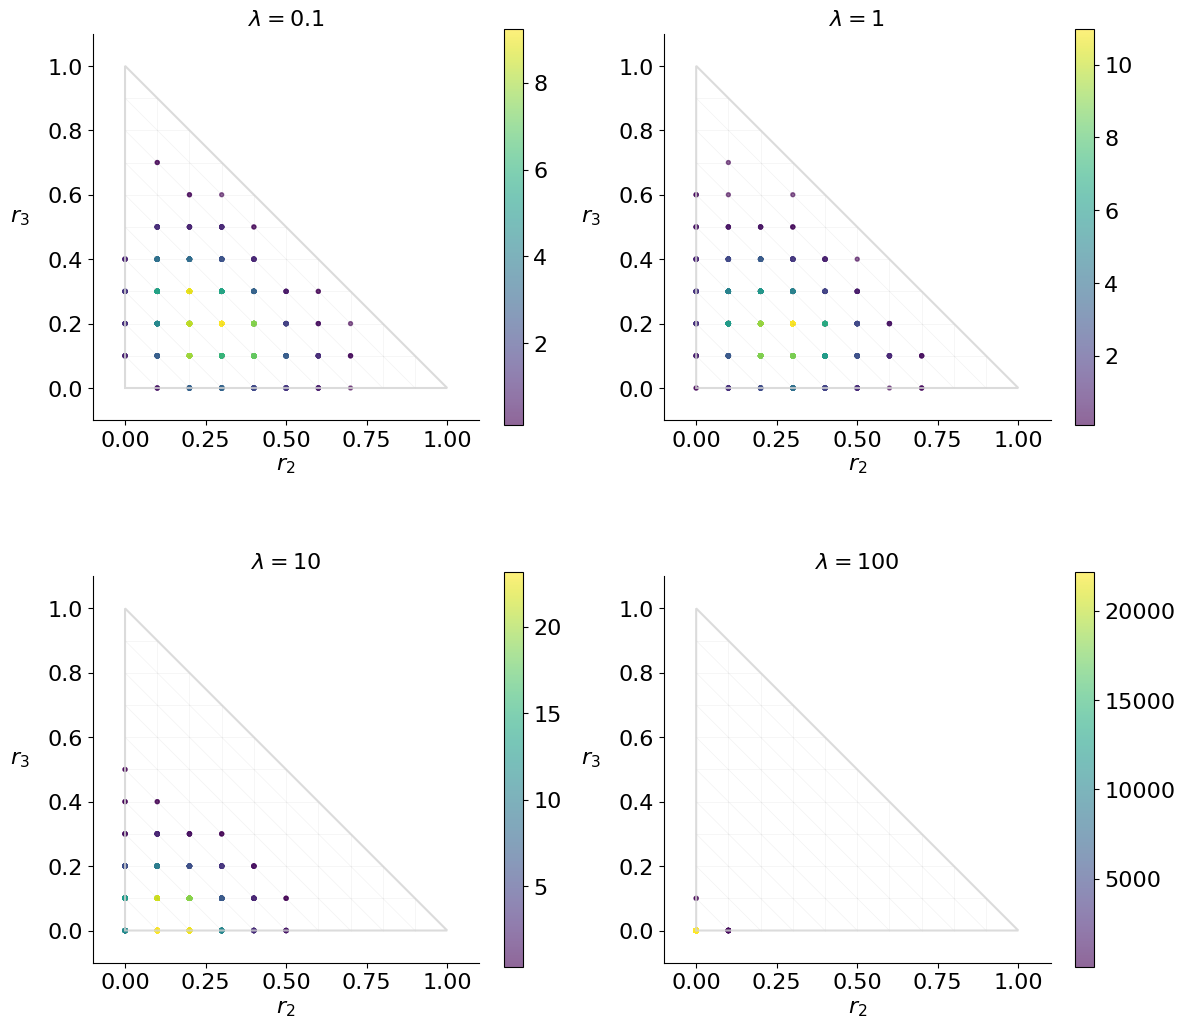

In [33]:
lambdas = [0.1, 1, 10, 100]
alpha_base = [0.52, 0.27, 0.21]
pl_scores = {1: 520, 2: 270, 3: 210}
num_samples = 10

np.random.seed(42)
# Create figure with 2x3 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 11))
#fig.suptitle('Dirichlet Distribution Samples with Different λ Values', fontsize=18, y=0.98)

# Flatten axes array for easier iteration
axes_flat = axes.flatten()


for i, (lam, ax) in enumerate(zip(lambdas, axes_flat)):

    # Sample from the Dirichlet distribution
    samples = get_sample_prs(pl_scores, lam, num_voters, 10)
    print(samples)
    title = f'$\\lambda = {lam}$'
    plot_marshak_machina_density_for_prob(samples, method='scatter_density', 
                                title=title,
                                cmap='viridis', alpha=0.6, s=8, ax=ax)
    
    # Print summary statistics
    mean_probs = np.mean(samples, axis=0)
    std_probs = np.std(samples, axis=0)
    print(f"\nλ = {lam}:")
    print(f"  Mean probabilities: [{mean_probs[0]:.3f}, {mean_probs[1]:.3f}, {mean_probs[2]:.3f}]")
    print(f"  Std deviations: [{std_probs[0]:.3f}, {std_probs[1]:.3f}, {std_probs[2]:.3f}]")

plt.tight_layout()
plt.savefig("graphs/dirichlet_probs.pdf", bbox_inches="tight")
plt.show()

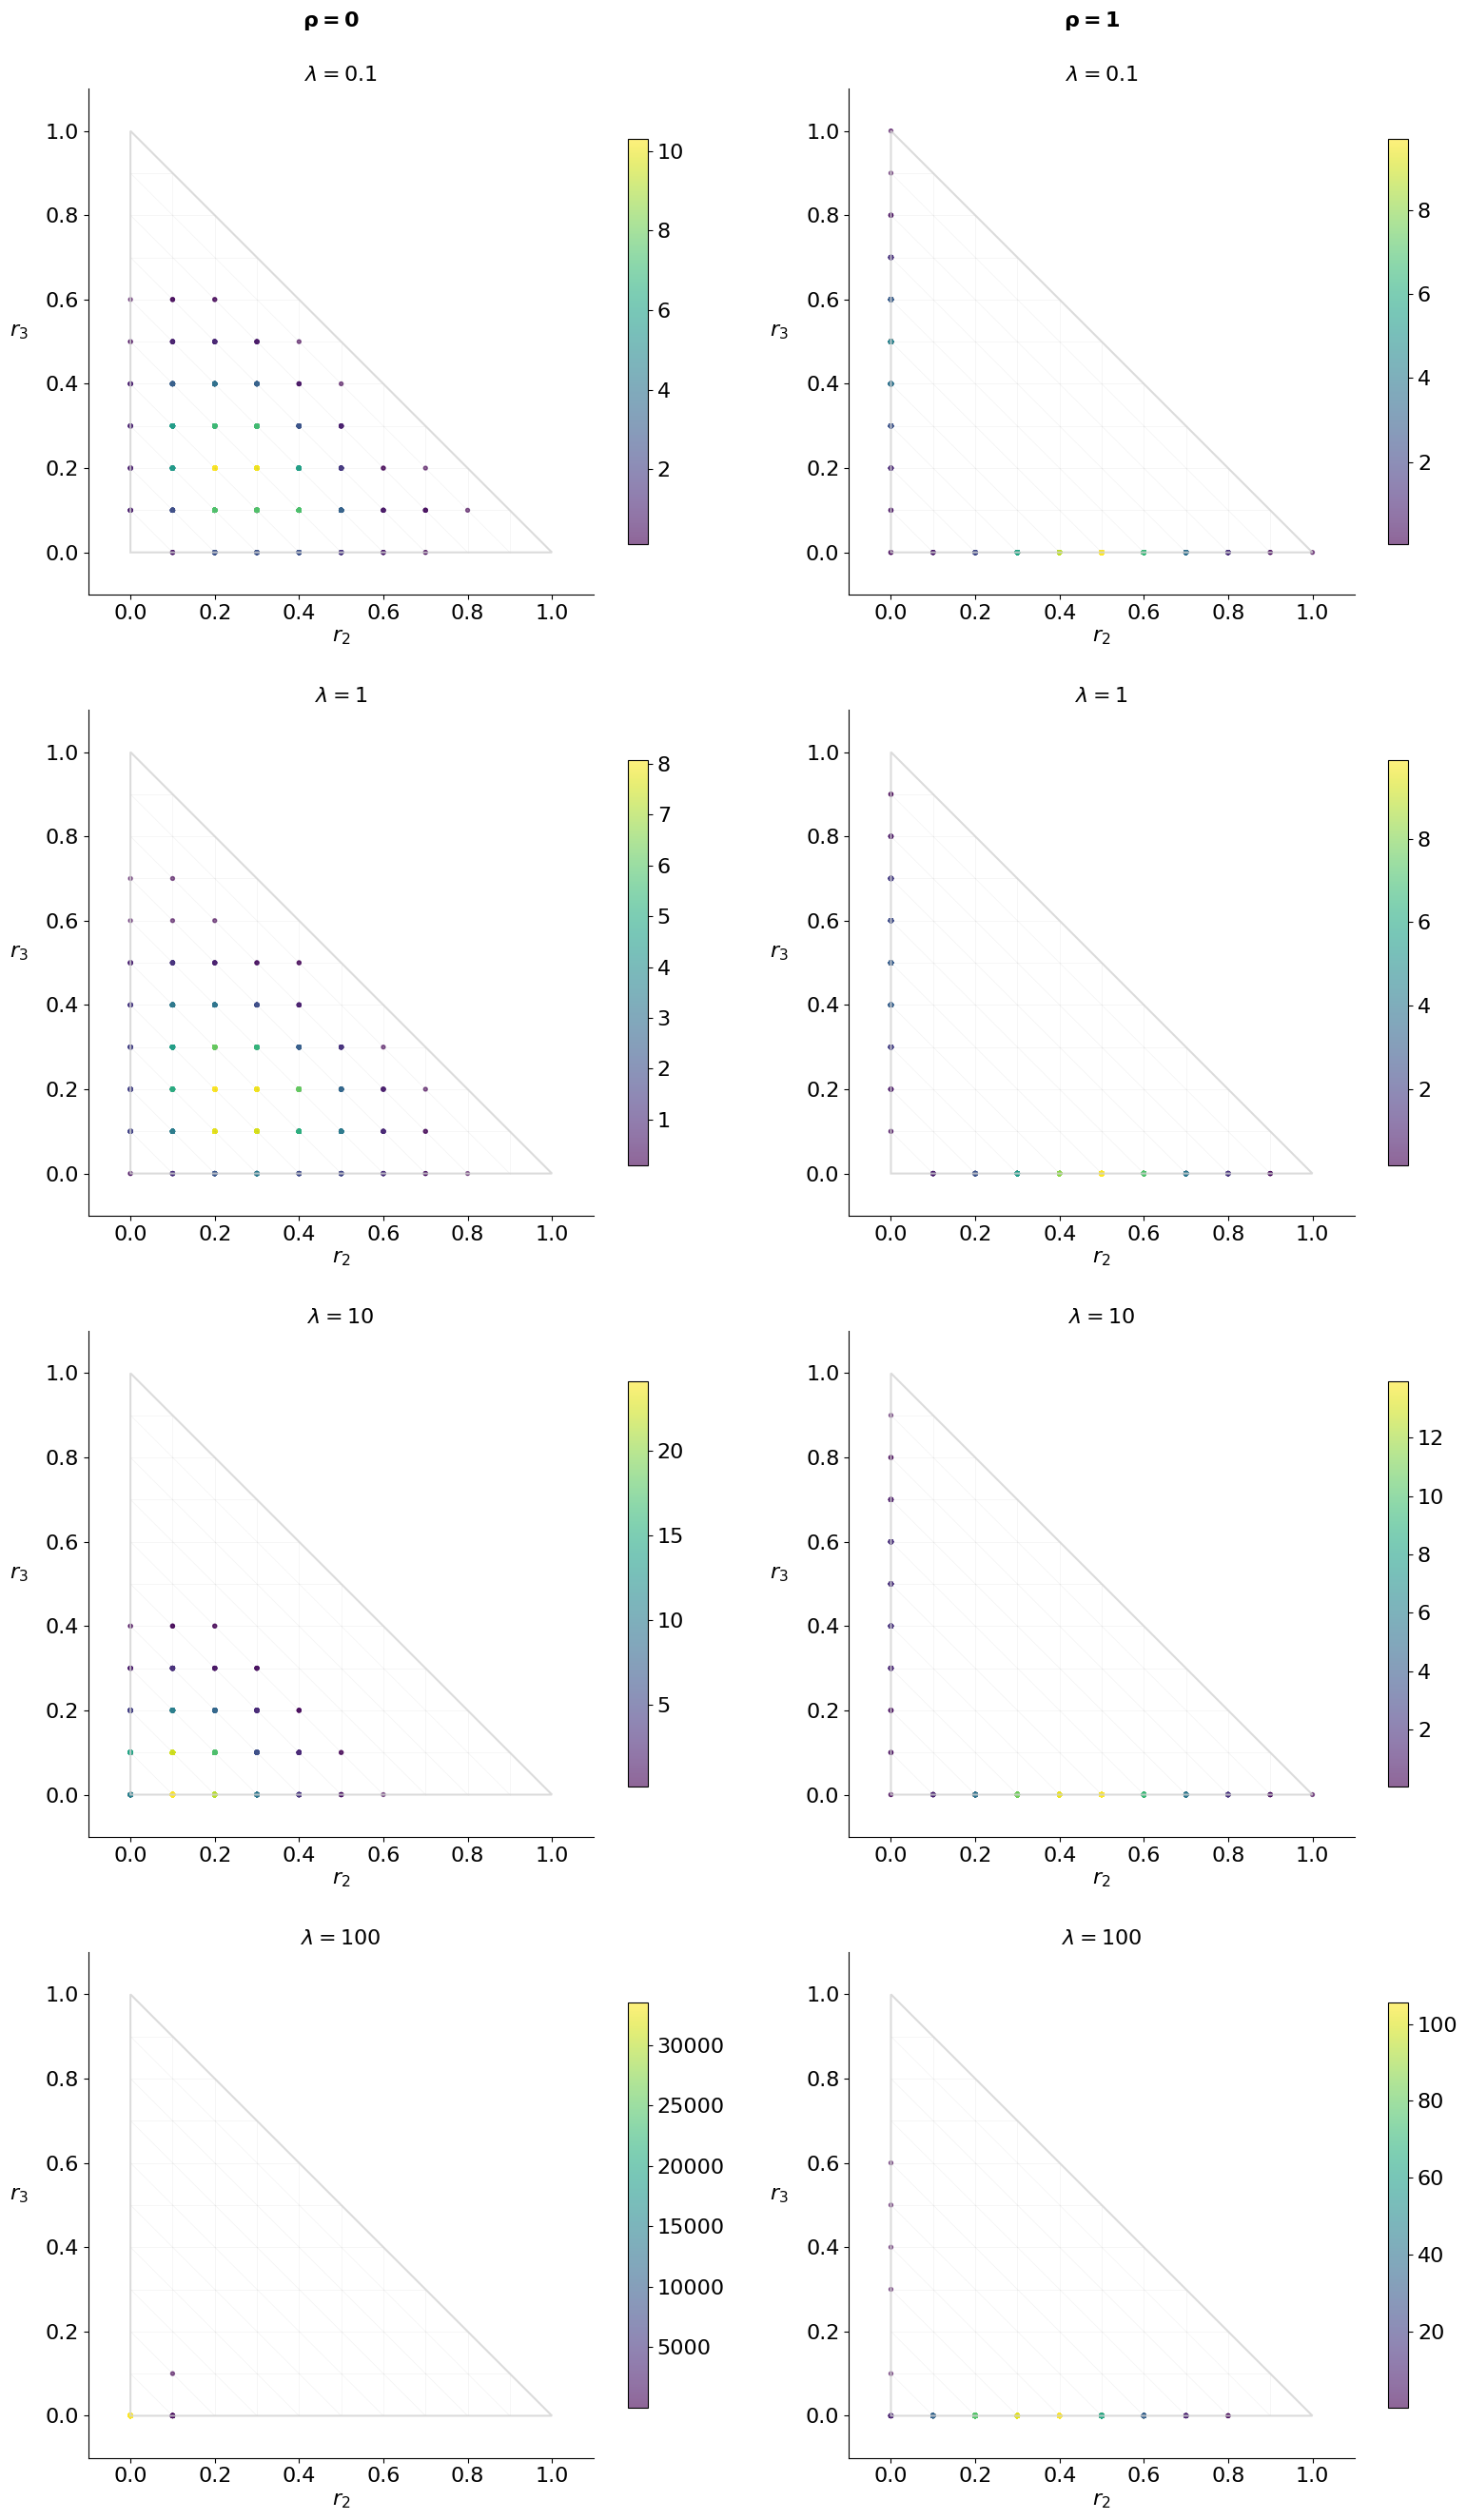

In [34]:
lambdas = [0.1, 1, 10, 100]
alpha_base = [0.52, 0.27, 0.21]
pl_scores = {1: 520, 2: 270, 3: 210}
num_samples = 10

np.random.seed(2)

fig, axes = plt.subplots(4, 2, figsize=(16, 26))

# Add column headers
fig.text(0.23, 1.01, '$\\mathbf{\\rho=0}$', fontsize=16, ha='center', fontweight='bold')
fig.text(0.73, 1.01, '$\\mathbf{\\rho=1}$', fontsize=16, ha='center', )

# Iterate through lambdas
for i, lam in enumerate(lambdas):
    # Get both types of samples
    samples = get_sample_prs(pl_scores, lam, num_voters, 10)
    strategic_samples = get_sample_strategic_prs(pl_scores, lam, num_voters, 10)
    
    # Plot regular samples in left column (column 0)
    ax_left = axes[i, 0]
    title_left = f'$\\lambda = {lam}$'
    plot_marshak_machina_density_for_prob(samples, method='scatter_density', 
                                        title=title_left,
                                        cmap='viridis', alpha=0.6, s=8, ax=ax_left)
    
    # Plot strategic samples in right column (column 1)
    ax_right = axes[i, 1]
    title_right = f'$\\lambda = {lam}$'
    plot_marshak_machina_density_for_prob(strategic_samples, method='scatter_density', 
                                        title=title_right,
                                        cmap='viridis', alpha=0.6, s=8, ax=ax_right)


plt.tight_layout(h_pad=3.0)
plt.savefig("graphs/dirichlet_with_strats.pdf", bbox_inches="tight")
plt.show()